# Tokenizer

In [2]:
import os
import random 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Flatten, Dropout, Input, GlobalMaxPooling1D, concatenate

Traemos nuestro CSV

In [3]:
df = pd.read_csv('data.csv')

Removemos saltos de linea o tabulaciones.

In [4]:
def quit_space(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    return text

# Split y Tokenizer
Realizamos la division de nuestro data set en 0.2 y 0.8 y luego tokenizamos nuestra data, para que esta fuera leida como vectores numericos.

In [5]:
from sklearn.model_selection import train_test_split

df['Code1'] = df['Code1'].apply(quit_space)
df['Code2'] = df['Code2'].apply(quit_space)

x_features = df[['Code1', 'Code2']]
y_labels = df['Plagio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=42)

# Tokenización y padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['Code1'] + X_train['Code2'])

X_train_code1_sequences = tokenizer.texts_to_sequences(X_train['Code1'])
X_train_code2_sequences = tokenizer.texts_to_sequences(X_train['Code2'])
X_test_code1_sequences = tokenizer.texts_to_sequences(X_test['Code1'])
X_test_code2_sequences = tokenizer.texts_to_sequences(X_test['Code2'])

max_length = max(max(len(seq) for seq in X_train_code1_sequences), max(len(seq) for seq in X_train_code2_sequences))

X_train_code1_padded = pad_sequences(X_train_code1_sequences, maxlen=max_length, padding='post', truncating='post')
X_train_code2_padded = pad_sequences(X_train_code2_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_code1_padded = pad_sequences(X_test_code1_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_code2_padded = pad_sequences(X_test_code2_sequences, maxlen=max_length, padding='post', truncating='post')

print(max_length)


5417


# Definicion de CNN
Defininmos nuestro CNN y sus capas respectivas.

In [ ]:
from tensorflow.keras.models import Model

embedding_dim = 100
num_filters = 64
filter_sizes = [3, 4, 5]
dropout_rate = 0.5


input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))

embedding = Embedding(len(tokenizer.word_index) + 1, embedding_dim)

conv_blocks = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')
    conv_block1 = conv(embedding(input1))
    conv_block2 = conv(embedding(input2))
    pool1 = GlobalMaxPooling1D()(conv_block1)
    pool2 = GlobalMaxPooling1D()(conv_block2)
    conv_blocks.extend([pool1, pool2])


if len(filter_sizes) > 1:
    merged = concatenate(conv_blocks)
else:
    merged = conv_blocks[0]

dropout = Dropout(0.5)(merged)
dense1 = Dense(64, activation='relu')(dropout)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[input1, input2], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit([X_train_code1_padded, X_train_code2_padded], y_train, epochs=100, batch_size=64, validation_data=([X_test_code1_padded, X_test_code2_padded], y_test))

Evaluamos nuestro modelo.

In [7]:
# Evaluat the model
loss, accuracy = model.evaluate([X_test_code1_padded, X_test_code2_padded], y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - acc: 0.9375 - loss: 0.2318

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - acc: 0.9537 - loss: 0.1770
Loss: 0.1834174394607544
Accuracy: 0.9508196711540222


Desplegamos nuestra matriz de confusion.

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
Matriz de Confusión:
[[173   2]
 [  7   1]]


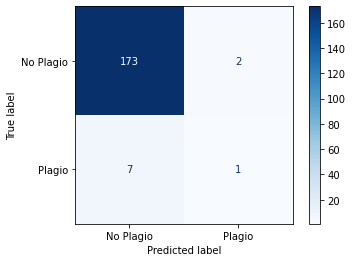

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Predicciones en los datos de prueba
y_pred = model.predict([X_test_code1_padded, X_test_code2_padded])
y_pred_classes = np.round(y_pred)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['No Plagio', 'Plagio'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


Realizamos pruebas con test.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, precision_score

# Convertir las probabilidades en clases predichas (ajusta según tu problema de clasificación)
y_pred_test = (y_pred > 0.8).astype("int32")  # Para problemas binarios

# Calcular F1 y Recall
f1 = f1_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')

# Para obtener un reporte completo
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n", report)


In [ ]:
print("F1 Score Test: {:.2f}%".format(f1 * 100))
print("Recall Test: {:.2f}%".format(recall * 100))
print("Accuracy Test: {:.2f}%".format(accuracy * 100))
print("Precision Test: {:.2f}%".format(precision * 100))



F1 Score Test: 48.88%
Recall Test: 50.00%
Accuracy Test: 95.63%
Precision Test: 47.81%


Queries al Codigo.

In [ ]:
def es_plagio(code1, code2):
    # Preprocesamiento de los códigos
    # code1 = quit_space(code1)
    # code2 = quit_space(code2)
    
    # Tokenización y padding
    code1_sequence = tokenizer.texts_to_sequences([code1])
    code2_sequence = tokenizer.texts_to_sequences([code2])
    
    code1_padded = pad_sequences(code1_sequence, maxlen=max_length, padding='post', truncating='post')
    code2_padded = pad_sequences(code2_sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Predicción del modelo
    plagiarism_prob = model.predict([code1_padded, code2_padded])
    print(plagiarism_prob)
    
    # Si la probabilidad de plagio es alta (por ejemplo, mayor que 0.5), se considera plagio
    if plagiarism_prob > 0.2:
        return "Plagio detectado."
    else:
        return "No hay plagio."



In [ ]:
code1 = """
public class AreaTriangulo {

    public static void main(String[] args) {
        // Declaración de variables
        double base = 5.0;
        double altura = 3.0;
        double area;

        // Cálculo del área
        area = (base * altura) / 2;

        // Impresión del resultado
        System.out.println("El área del triángulo es: " + area);
    }
}"""

code2 = """ 
public class AreaTriangulo {

    public static void main(String[] args) {
        // Declaración de variables en orden inverso
        double altura = 3.0;
        double base = 5.0;
        double area;

        // Cálculo del área (mismo que el código 1)
        area = (base * altura) / 2;

        // Impresión del resultado (mismo que el código 1)
        System.out.println("El área del triángulo es: " + area);
    }
}"""

# Test de la función con los códigos proporcionados
resultado = es_plagio(code1, code2)
print(resultado)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.22453178]]
Plagio detectado.
